In [21]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Activation, BatchNormalization, MaxPool2D
import data_preprocessing as dp

import models.training as train
import utilities

In [22]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Import data

In [23]:
rf_data = {key:tf.data.experimental.load(f'dataset/preprocessed/reshaped_pca98train_ds/{key}')
           for key in ('train', 'test', 'valid')}
channel_data = {key:tf.data.experimental.load(f'dataset/preprocessed/channel_pca98train_ds/{key}')
           for key in ('train', 'test', 'valid')}
time_data = {key:tf.data.experimental.load(f'dataset/preprocessed/time_pca98train_ds/{key}')
             for key in ('train', 'test', 'valid')}

### Dense Model

In [127]:
class FF(Model):
    def __init__(self, input_dim):
        """
        init: constructor of model
        call: performs forward pass of model
        """
        super(FF, self).__init__()
        self.input_dim = input_dim
        self.layer_list = [
            Dense(self.input_dim, activation="sigmoid"),
            #Dense(258, activation="sigmoid"),
            #Dense(128, activation="sigmoid"),
            #Dense(64, activation="sigmoid"),
            #Dense(16, activation="sigmoid"),
            Dropout(rate= 0.2),
            Dense(4, activation= "softmax")
        ]

    @tf.function
    def call(self, inputs) -> tf.Tensor:
        """ Computes a forward step with the given data
        Parameters
        ----------
        inputs : tf.Tensor
            the input for the model
        training : bool
            true if call has been made from train_step, which tells the dropout layer to be active
        Returns
        ----------
        x : tf.Tensor
            the output of the model
        """
        x = inputs
        for layer in self.layer_list:
            x = layer(x)
        return x


In [134]:
dense = FF(20)
dense.build((None, 1319))
dense.summary()

Model: "ff_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             multiple                  26400     
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_65 (Dense)             multiple                  84        
Total params: 26,484
Trainable params: 26,484
Non-trainable params: 0
_________________________________________________________________


In [135]:
# Initialize the loss-function
loss_func = tf.losses.CategoricalCrossentropy()
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.05)

In [136]:
# Initialize Train-Object
trainer_1 = train.Trainer(dense, rf_data,
                        optimizer, loss_func, train.accuracy)

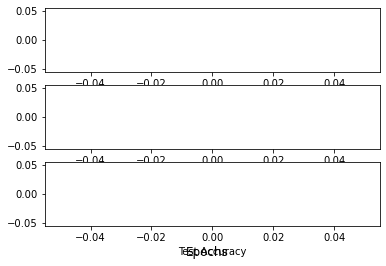

In [137]:
# Initialize Plotting-Object
grapher_1 = utilities.TrainingGrapher(3, 1, supxlabel='Epochs',
                                    axs_xlabels=[['Train Loss', 'Test Loss', 'Test Accuracy']])

In [159]:
for epoch in range(100):
    print("Epoch:", epoch, end='\r')
    trainer_1.train_epoch()
    grapher_1.update([trainer_1.losses['train'], trainer_1.losses['test'], trainer_1.accuracies['test']])

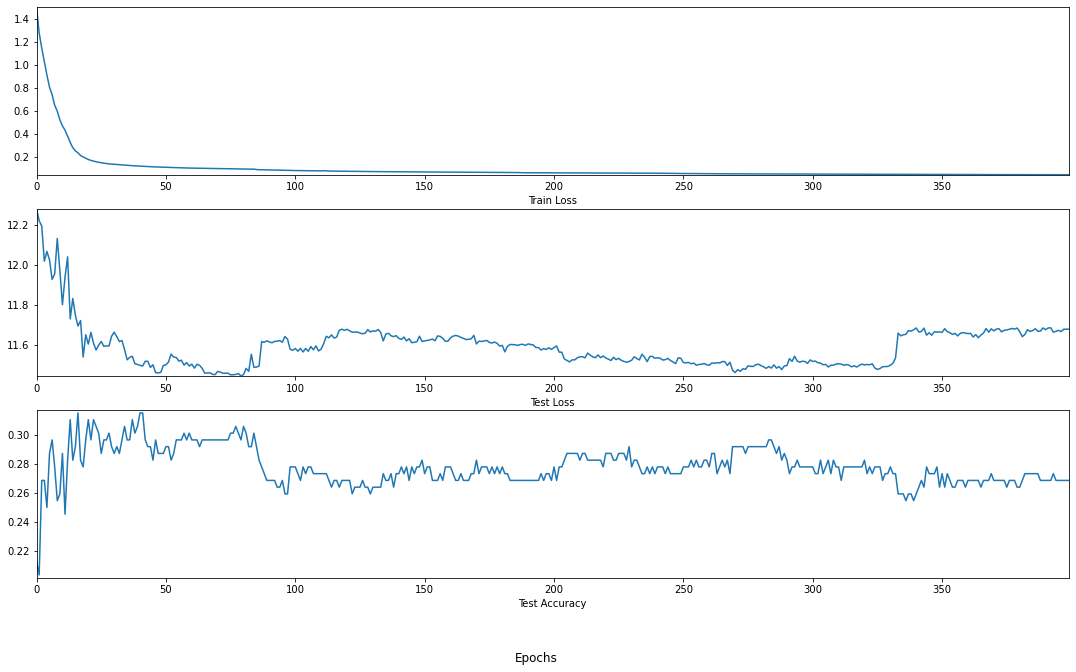

In [160]:
%matplotlib inline
grapher_1.fig.set_size_inches(18.5, 10.5)
grapher_1.fig

### CNN

In [142]:
class Conv(Model):
    def __init__(self):
        """
        init: constructor of model
        call: performs forward pass of model
        """
        super(Conv, self).__init__()

        self.layer_list = [
            #Conv2D(filters=32, kernel_size=(3,3), padding = 'same'),
            #BatchNormalization(),
            #LeakyReLU(),
            #MaxPool2D(),
            Conv2D(filters=16, kernel_size=(3,3), padding = 'same'),
            BatchNormalization(),
            LeakyReLU(),
            Dropout(0.3),
            MaxPool2D(),
            Conv2D(filters=8, kernel_size=(3,3), padding = 'same'),
            BatchNormalization(),
            LeakyReLU(),
            tf.keras.layers.GlobalAveragePooling2D(),
            Dense(4, activation='softmax')
        ]

    @tf.function
    def call(self, inputs) -> tf.Tensor:
        """ Computes a forward step with the given data
        Parameters
        ----------
        inputs : tf.Tensor
            the input for the model
        training : bool
            true if call has been made from train_step, which tells the dropout layer to be active
        Returns
        ----------
        x : tf.Tensor
            the output of the model
        """
        x = inputs
        for layer in self.layer_list:
            x = layer(x)
        return x

In [143]:
model = Conv()
model.build((None, 46, 640, 1))
model.summary()

Model: "conv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  160       
_________________________________________________________________
batch_normalization (BatchNo multiple                  64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  1160      
_________________________________________________________________
batch_normalization_1 (Batch multiple                  32     

In [144]:
#%matplotlib tk
# Initialize the loss-function
loss_func = tf.losses.CategoricalCrossentropy()
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()



In [145]:
# Initialize Train-Object
trainer = train.Trainer(model, channel_data,
                        optimizer, loss_func, train.accuracy)

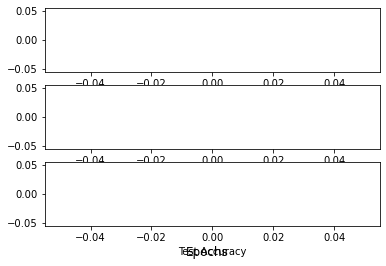

In [146]:
# Initialize Plotting-Object
grapher = utilities.TrainingGrapher(3,1, supxlabel='Epochs', axs_xlabels=[['Train Loss', 'Test Loss', 'Test Accuracy']])

In [155]:
for epoch in range(10):
    print("Epoch:", epoch, end='\r')
    trainer.train_epoch()
    grapher.update([trainer.losses['train'], trainer.losses['test'], trainer.accuracies['test']])

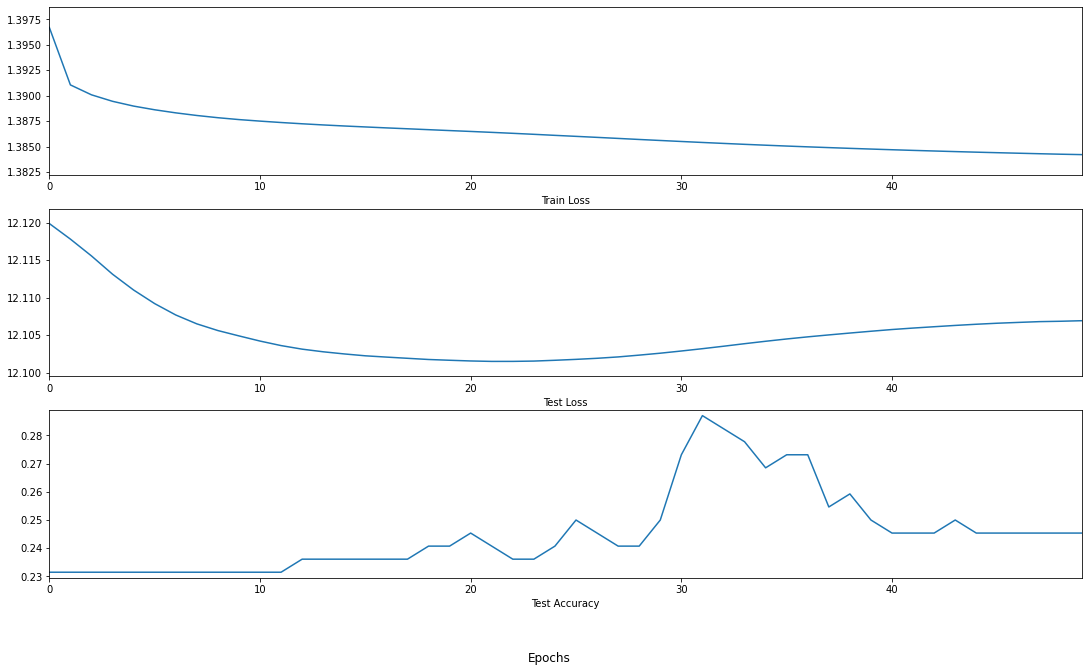

In [156]:
%matplotlib inline
grapher.fig.set_size_inches(18.5, 10.5)
grapher.fig